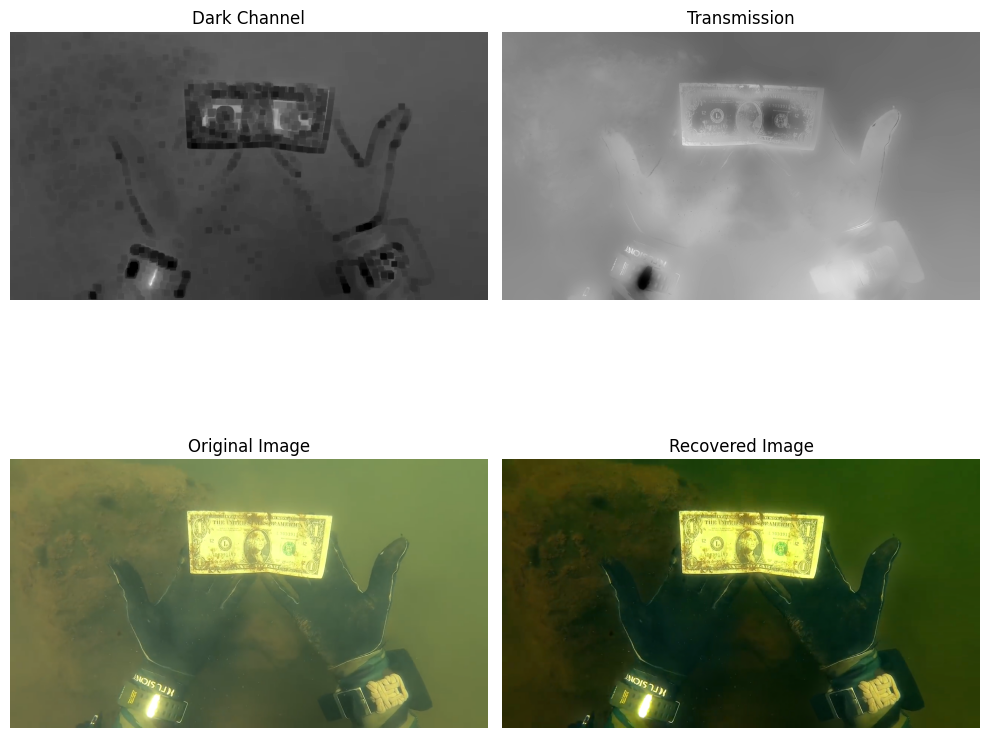

True

In [2]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

def DarkChannel(im, sz):
    b, g, r = cv2.split(im)
    dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (sz, sz))
    dark = cv2.erode(dc, kernel)
    return dark

def AtmLight(im, dark):
    [h, w] = im.shape[:2]
    imsz = h * w
    numpx = int(max(math.floor(imsz / 1000), 1))
    darkvec = dark.reshape(imsz)
    imvec = im.reshape(imsz, 3)

    indices = darkvec.argsort()
    indices = indices[imsz - numpx::]

    atmsum = np.zeros([1, 3])
    for ind in range(1, numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx
    return A

def TransmissionEstimate(im, A, sz):
    omega = 0.95
    im3 = np.empty(im.shape, im.dtype)

    for ind in range(0, 3):
        im3[:, :, ind] = im[:, :, ind] / A[0, ind]

    transmission = 1 - omega * DarkChannel(im3, sz)
    return transmission

def Guidedfilter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    q = mean_a * im + mean_b
    return q

def TransmissionRefine(im, et):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray) / 255
    r = 60
    eps = 0.0001
    t = Guidedfilter(gray, et, r, eps)

    return t

def Recover(im, t, A, tx=0.1):
    res = np.empty(im.shape, im.dtype)
    t = cv2.max(t, tx)

    for ind in range(0, 3):
        res[:, :, ind] = (im[:, :, ind] - A[0, ind]) / t + A[0, ind]

    return res

fn = 'C:/College Projects/Applied LA for ML/5426a351-39e9-478c-8775-5fbcd69d30e5/raw/raw-890/15544.png'
src = cv2.imread(fn)
I = src.astype('float64') / 255

dark = DarkChannel(I, 15)
A = AtmLight(I, dark)
te = TransmissionEstimate(I, A, 15)
t = TransmissionRefine(src, te)
J = Recover(I, t, A, 0.1)

plt.figure(figsize=(10, 10))

# Dark Channel
plt.subplot(2, 2, 1)
plt.imshow(dark, cmap='gray')
plt.title('Dark Channel')
plt.axis('off')

# Transmission
plt.subplot(2, 2, 2)
plt.imshow(t, cmap='gray')
plt.title('Transmission')
plt.axis('off')

# Original Image
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Recovered Image
plt.subplot(2, 2, 4)
J_display = np.clip(J, 0, 1)
J_display_uint8 = (J_display * 255).astype(np.uint8)
J_rgb = cv2.cvtColor(J_display_uint8, cv2.COLOR_BGR2RGB)
plt.imshow(J_rgb)
plt.title('Recovered Image')
plt.axis('off')

plt.tight_layout()
plt.show()
cv2.imwrite("output.png", J * 255)
